In [ ]:
import torch
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


#Build our own CNN

In [ ]:
import torch.nn as nn

In [ ]:
class MyCNN(nn.Module):
  def __init__(self):
    super(MyCNN, self).__init__()
    self.features = nn.Sequential(    #Assume input image H/W=224
        nn.Conv2d(3, 32, 3, 1, 1), #feature map H/W=(64+2*1-3)/1+1 = 224
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2, 0),    #H/W=(64+2*0-2)/2+1 = 112
        nn.Conv2d(32, 8, 3, 1, 1), #H/W=(32+2*1-3)/1+1 = 112
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2, 0),    #H/W=(32+2*0-2)/2+1 = 56
    )
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(8 * 56 * 56, 500),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(500, 100),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(100, 2),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [ ]:
model = MyCNN().to(device)
print(model)

MyCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=25088, out_features=500, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=500, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=100, out_features=2, bias=True)
  )
)


In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4          [-1, 8, 112, 112]           2,312
              ReLU-5          [-1, 8, 112, 112]               0
         MaxPool2d-6            [-1, 8, 56, 56]               0
           Dropout-7                [-1, 25088]               0
            Linear-8                  [-1, 500]      12,544,500
              ReLU-9                  [-1, 500]               0
          Dropout-10                  [-1, 500]               0
           Linear-11                  [-1, 100]          50,100
             ReLU-12                  [-1, 100]               0
          Dropout-13                  [-1, 100]               0
           Linear-14                   

In [ ]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

#Upload an image file to Colab

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Arranged married to HIM.jpg to Arranged married to HIM.jpg


In [ ]:
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

Arranged married to HIM.jpg


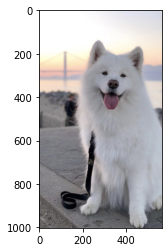

In [ ]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread(fname)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

# Image processing - resize, center crop, standarize to [0, 1], normalized to N(0,1)

In [ ]:
from torchvision import transforms
transformer = transforms.Compose([
     transforms.Resize(224),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5] )])

In [ ]:
from PIL import Image
PILImg= Image.fromarray(image.astype('uint8')).convert('RGB')
PILImg = transformer(PILImg)
PILImg.shape

torch.Size([3, 224, 224])

In [ ]:
imageTensor = torch.unsqueeze(PILImg, 0)
imageTensor.shape

torch.Size([1, 3, 224, 224])

(224, 224, 3) 0.0 1.0


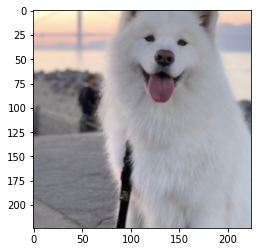

In [ ]:
#visualize the image after pre-processing
# Tensor is channel first, to plot, we need to convert to channel last
import numpy as np
PILImgArray = np.zeros((PILImg.shape[1], PILImg.shape[2], 3))
PILImgArray[:,:,0] = PILImg[0, :, :]
PILImgArray[:,:,1] = PILImg[1, :, :]
PILImgArray[:,:,2] = PILImg[2, :, :]
PILImgArray = PILImgArray*0.5+0.5  # change N(0, 1) to [0, 1]
print(PILImgArray.shape, PILImgArray.min(), PILImgArray.max())
plt.imshow(PILImgArray)
plt.show()

#Apply 1st convolution and pooling

In [ ]:
conv1 = model.features[0]
print(conv1)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
weight1 = conv1.weight.data.cpu().numpy()
print(weight1.shape)

(32, 3, 3, 3)


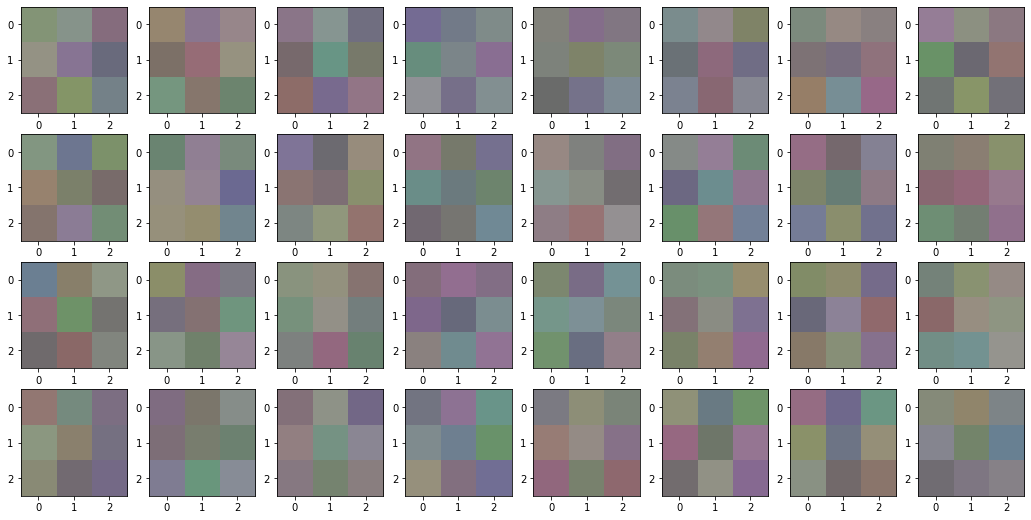

In [ ]:
# Visualize the first 32 of the filter weights
import numpy as np
fig=plt.figure(figsize=(18, 9))
for i in range(32):
  fig.add_subplot(4, 8, i+1)
  w = weight1[i]
  ImgArray = np.zeros((w.shape[1], w.shape[2], 3))
  ImgArray[:,:,0] = w[0, :, :]
  ImgArray[:,:,1] = w[1, :, :]
  ImgArray[:,:,2] = w[2, :, :]
  ImgArray = ImgArray*0.5+0.5  # convert[-1, 1] to [0, 1]
  plt.imshow(ImgArray)
plt.show()

In [ ]:
conv1_out = conv1(imageTensor.to(device))
conv1_out.shape
#output image (feature map) has 64 channels

torch.Size([1, 32, 224, 224])

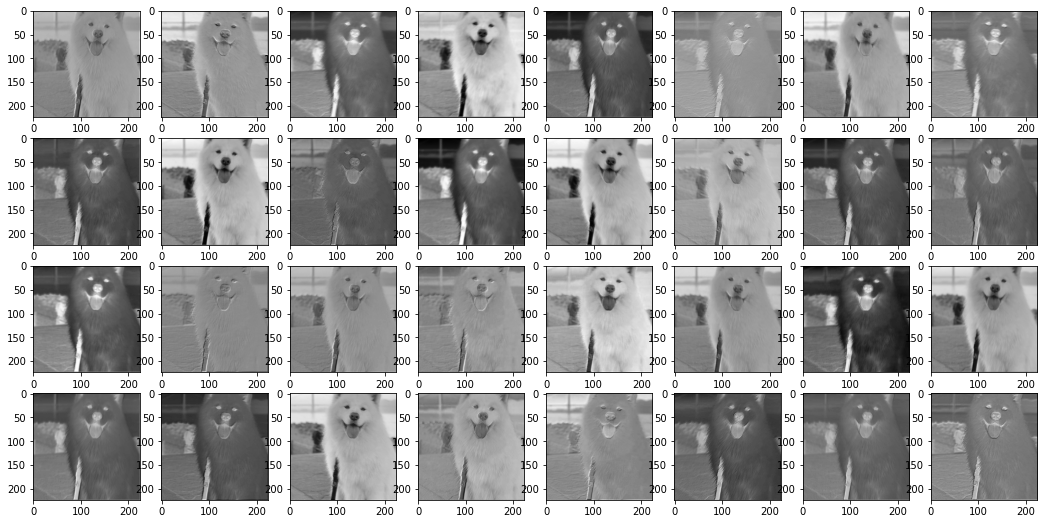

In [ ]:
# Visualize the first 32 channels of the output feature map
imgArray=conv1_out[0].data.cpu().numpy()
fig=plt.figure(figsize=(18, 9))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(imgArray[i], cmap='gray')
plt.show()

torch.Size([1, 32, 112, 112])


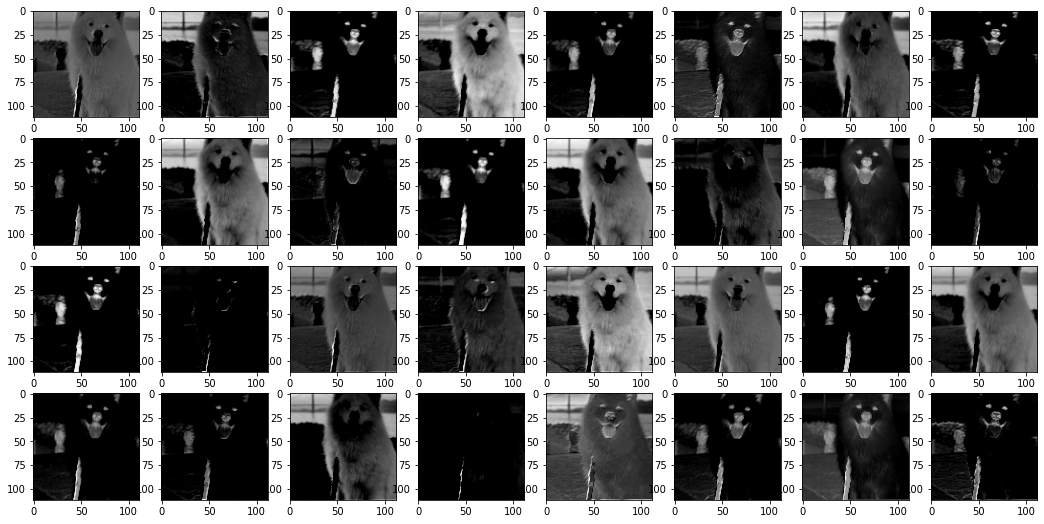

In [ ]:
# Max pooling
conv1_pooling = model.features[1:3]
conv1_out1 = conv1_pooling(conv1_out)
print(conv1_out1.shape)
imgArray=conv1_out1[0].data.cpu().numpy()
fig=plt.figure(figsize=(18, 9))
for i in range(32): #visualize the first 32 channels
  fig.add_subplot(4, 8, i+1)
  plt.imshow(imgArray[i], cmap='gray')
plt.show()

#Pass the output feature map to the 2nd convolution and pooling

torch.Size([1, 8, 112, 112])


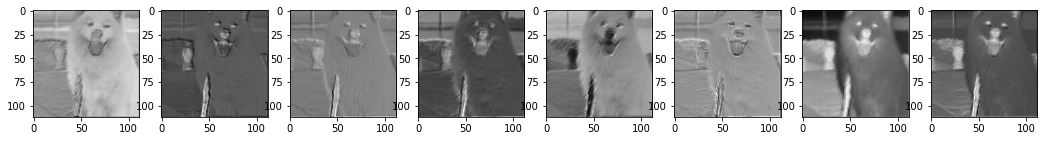

In [ ]:
conv2 = model.features[3]
conv2_out = conv2(conv1_out1)
print(conv2_out.shape)
imgArray=conv2_out[0].data.cpu().numpy()
fig=plt.figure(figsize=(18, 9))
for i in range(8): #visualize all 8 channels
  fig.add_subplot(4, 8, i+1)
  plt.imshow(imgArray[i], cmap='gray')
plt.show()

torch.Size([1, 8, 56, 56])


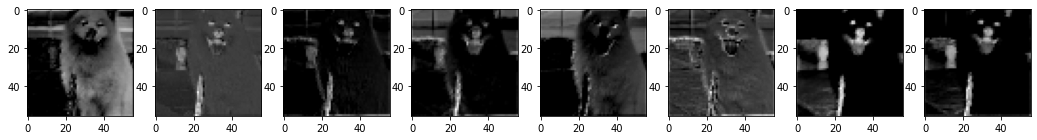

In [ ]:
# Max pooling
conv2_pooling = model.features[4:6]
conv2_out1 = conv2_pooling(conv2_out)
print(conv2_out1.shape)
imgArray=conv2_out1[0].data.cpu().numpy()
fig=plt.figure(figsize=(18, 9))
for i in range(8): #visualize all 8 channels
  fig.add_subplot(4, 8, i+1)
  plt.imshow(imgArray[i], cmap='gray')
plt.show()

#Pass input image through my CNN

In [ ]:
WholeConvLayers = model.features
out1 = WholeConvLayers(imageTensor.to(device))
print(out1.shape)

torch.Size([1, 8, 56, 56])


In [ ]:
out2 = torch.flatten(out1, 1)
print(out2.shape)

torch.Size([1, 25088])


In [ ]:
ClassifierMLP = model.classifier
out = ClassifierMLP(out2)

In [ ]:
print(out)
print(torch.max(out))
print(torch.argmax(out))

tensor([[-0.0033,  0.0276]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor(0.0276, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1, device='cuda:0')
